In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [2]:
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha2.0_iris_.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 4.18791145e-01 -8.37097608e-01  2.85111335e-01  7.56306239e-01
  -3.30233813e-02 -5.26572962e-02 -4.96168769e-02 -3.77335647e-02
  -2.52160912e-02 -1.58141477e-02 -9.66403874e-03 -2.37329096e-02]
 [-1.79977978e-01  3.64128070e-01 -3.97594482e-01 -1.50073211e-03
  -2.92695316e-01 -2.52728547e-01 -1.96015931e-01 -1.35397674e-01
  -8.59861777e-02 -5.24821529e-02 -3.16017881e-02 -8.05459205e-02]
 [ 1.13956357e+00 -2.29445672e+00  1.63542773e+00  1.42543444e+00
   4.74936490e-01  3.43265804e-01  2.33699626e-01  1.47800272e-01
   8.90156166e-02  5.27246440e-02  3.12150324e-02  8.29554855e-02]
 [ 4.76318816e-01 -9.54591703e-01  3.75109194e-01  9.51122635e-01
   1.39571669e-01  8.93173300e-02  5.47958726e-02  3.25202276e-02
   1.91062601e-02  1.12581712e-02  6.67189495e-03  1.77798222e-02]]
	cluster_weights:
[6.47272092e-01 3.27266417e-01 1.15258663e-02 5.60261574e-03
 2.85576571e-03 1.85193925e-03 1.21650937e-03 8.04987559e-04
 5.34905723e-04 3.56178187e-04 2

In [5]:
print(model.prior_params)

prior_params:
	alpha: [2.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [6]:
alpha0 = model.prior_params['alpha'].get()[0]

# Define a perturbation in the logit v space.

In [7]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [8]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-0.6931471805599453 -2.741432260678122 -0.6938181120977465 -2.740761040524178


phi max:  0.4997727846542519


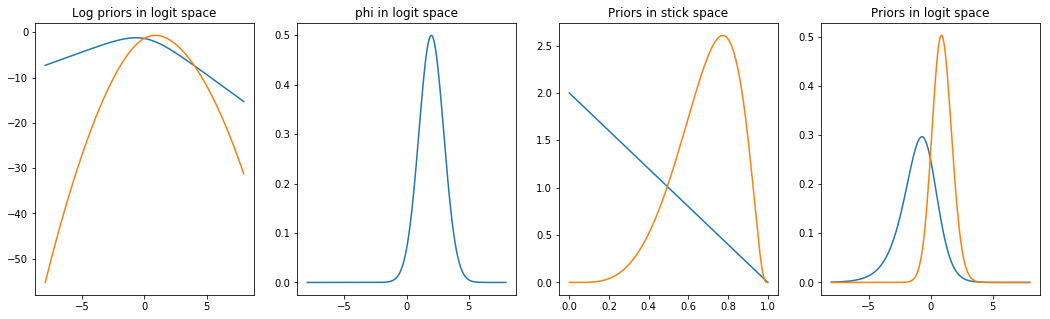

In [9]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                               prior_perturbation.logit_v_ub, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


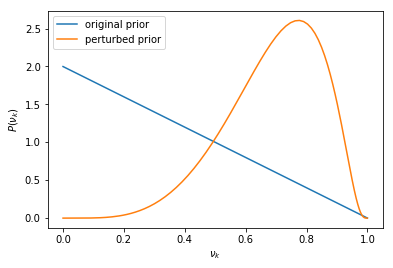

In [10]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/perturbed_prior2.png')

# Choose the number of GH points.

In [11]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

[1.67181793 1.0560706  3.66659207 4.55669875 5.74316332 5.8956162
 5.98229382 6.02944397 6.05321614 6.06488648 6.07079799]
[2.92606763e-16 2.92606763e-16 5.84751115e-16 7.33641631e-16
 5.85783939e-16 4.45403535e-16 2.65632362e-16 4.20510514e-16
 4.51951877e-16 3.01301251e-16 3.89834076e-16 4.45403535e-16
 2.96935690e-16 2.96935690e-16 3.01301251e-16 4.41920487e-16
 2.92891970e-16 4.84470680e-16 3.63353010e-16 5.93871380e-16
 4.45403535e-16 2.10255257e-16 3.89834076e-16 2.10255257e-16
 3.01301251e-16 2.94613658e-16 4.20510514e-16 7.79668153e-16
 4.39337954e-16 2.92891970e-16 1.94917038e-16 4.40184979e-16
 2.65632362e-16 3.98448543e-16 4.45403535e-16 4.41920487e-16
 2.92891970e-16 1.54649662e-16 2.10255257e-16 2.92606763e-16
 3.09299324e-16 2.94613658e-16 6.30765771e-16 4.20510514e-16
 2.93456652e-16 4.20510514e-16 4.20510514e-16 1.50650626e-16
 2.93456652e-16 6.05588350e-16 1.54649662e-16 4.84470680e-16
 2.10255257e-16 4.20510514e-16 1.50650626e-16 4.20510514e-16
 4.20510514e-16 4.45403

In [12]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 12.39081164361042	 Objective: -326.33755104989535
Iter: 1	 RMSE: 12.390802566895358	 Objective: -326.3375516001674
Iter: 2	 RMSE: 12.390802664681784	 Objective: -326.337551600353
Optimization terminated successfully.
         Current function value: -326.337552
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Iter: 3	 RMSE: 12.390802664681782	 Objective: -326.3375516003539
Iter: 4	 RMSE: 12.3908026635713	 Objective: -326.33755160035224
         Current function value: -326.337552
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


# Examine Fit 

In [13]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [14]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [15]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

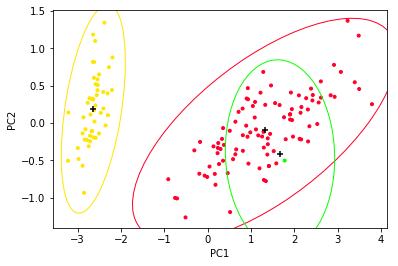

In [16]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

# plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [17]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        output_par=moment_model.moment_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=moment_model.set_moments,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [18]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

23.592553956460037

## Fit with perturbation

In [19]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  23.592553956460037


In [20]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0
Iter  0  value:  -127.29216333157616
Iter  1  value:  -152.1067125513742
Iter  2  value:  -169.89813529519915
Iter  3  value:  -186.07536905018068
Iter  4  value:  -212.53742523706032
Iter  5  value:  -239.15727226908083
Iter  6  value:  -258.94175220128386
Iter  7  value:  -280.00817611738074
Iter  8  value:  -282.5745878453108
Iter  9  value:  -297.2868968579753
Iter  10  value:  -298.7816710570467
Iter  11  value:  -286.9694536772114
Iter  12  value:  -301.9212771582211
Iter  13  value:  -302.78953928861523
Iter  14  value:  -303.7672668512833
Iter  15  value:  -306.336119405193
Iter  16  value:  -307.3684386620767
Iter  17  value:  -310.5000005315348
Iter  18  value:  -311.4491145663438
Iter  19  value:  -311.8888114402959
Iter  20  value:  -309.4782468671985
Iter  21  value:  -312.91967034147
Iter  22  value:  -313.94141742777316
Iter  23  value:  -314.1993978507389
Iter  24  value:  -315.07623054776553
Iter  25  value:  -315.86409497223934
Iter  26  value:  -316.1154

Epsilon: 1.0


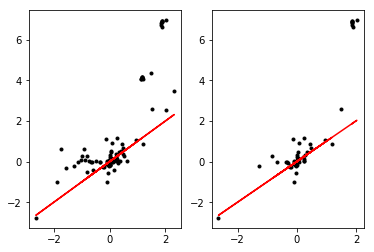

In [21]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [22]:
_ = model.set_from_global_free_par(best_param_0)
print('original expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

original expected number of clusters:  4.135185980249698


In [23]:
_ = model.set_from_global_free_par(best_param_phi)
print('perturbed expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

perturbed expected number of clusters:  5.191118697307077


In [24]:
_ = model.set_from_global_free_par(best_param_phi_pred)
print('predicted expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

predicted expected number of clusters:  3.93384819987377


# Predict for a range of perturbations

In [25]:
# epsilon_vec = np.arange(, 15)
epsilon_vec = np.linspace(0.1, 1, 10)
print(epsilon_vec)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [26]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [27]:
# best_param_phi_array = np.load('./best_param_phi_array.npy')

In [29]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('Epsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
        epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

    output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)

    print('Done. Converged: ', converged)

    print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    

Epsilon:  0.1
Predicted differences:  2.359255395646004
epsilon: 0.1
Iter  58  value:  -321.68141468084974
Iter  59  value:  -321.7924544488222
Iter  60  value:  -321.8062720638934
Iter  61  value:  -321.7881817859432
Iter  62  value:  -321.81180977098154
Iter  63  value:  -321.8511027208914
Iter  64  value:  -321.8462394676323
Iter  65  value:  -321.89352817828933
Iter  66  value:  -321.9409349956547
Iter  67  value:  -322.0679580198095
Iter  68  value:  -322.18761415500154
Iter  69  value:  -322.4010924657865
Iter  70  value:  -322.67976481821864
Iter  71  value:  -323.06086617971425
Iter  72  value:  -323.33919262195406
Iter  73  value:  -323.7496934104961
Iter  74  value:  -324.29017976617797
Iter  75  value:  -324.4169072887637
Iter  76  value:  -325.06921674775265
Iter  77  value:  -325.7351133682106
Iter  78  value:  -323.1887927039318
Iter  79  value:  -326.08578772902297
Iter  80  value:  -326.3803565499284
Iter  81  value:  -326.94821552759436
Iter  82  value:  -327.165948019

In [30]:
# np.save('best_param_phi_array', best_param_phi_array)

In [31]:
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

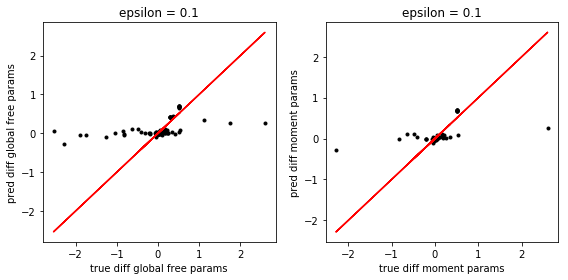

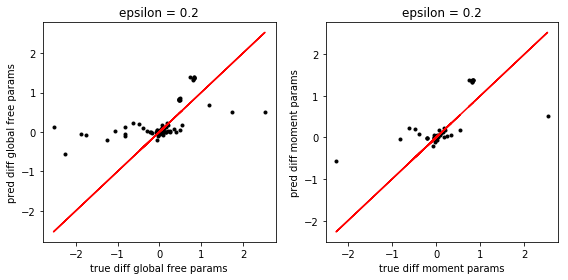

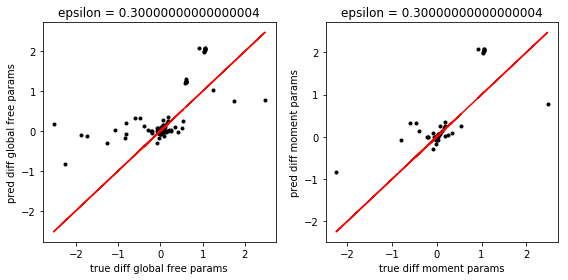

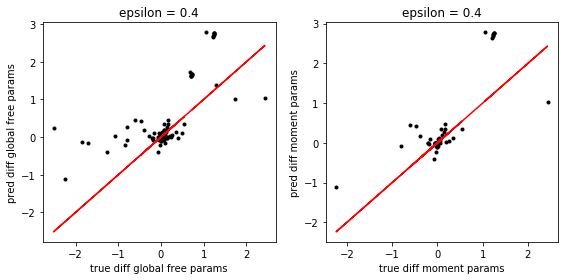

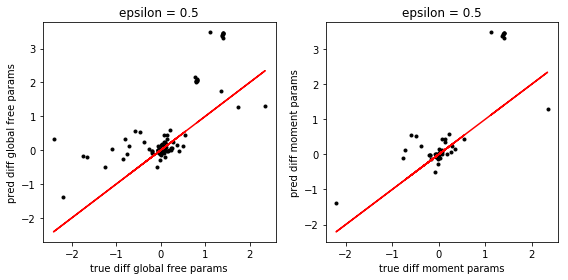

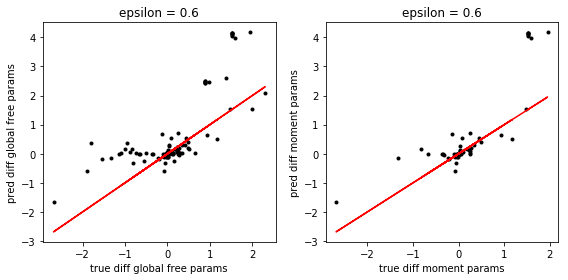

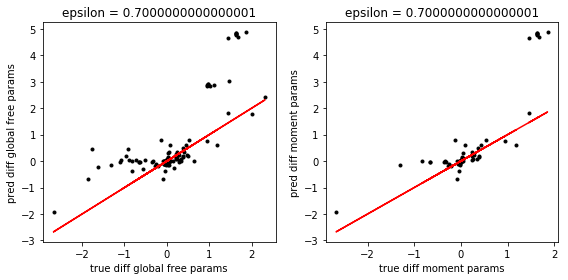

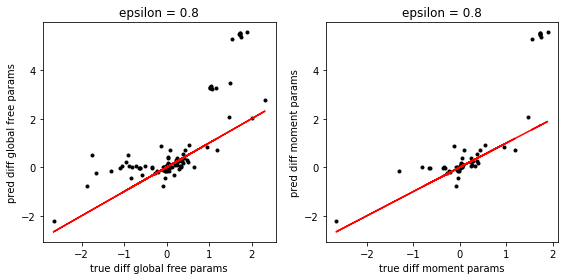

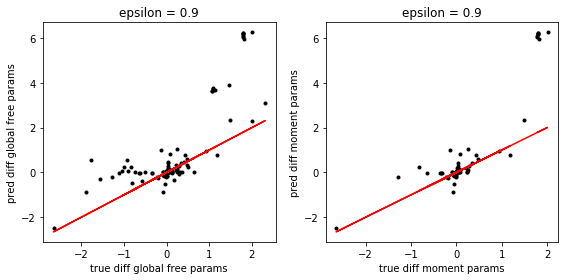

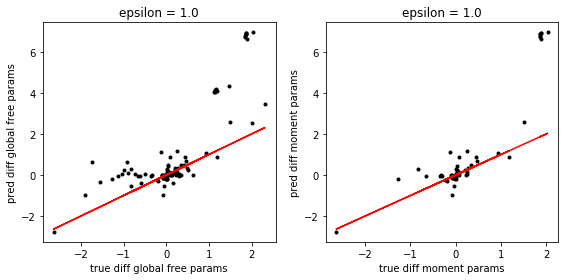

In [32]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_pred_array[i] - best_param_0, 'k.')
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_array[i] - best_param_0, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.subplot(1, 2, 2)
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_pred_array[i] - output_0, 'k.')
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_array[i] - output_0, 'r')
    plt.xlabel('true diff moment params')
    plt.ylabel('pred diff moment params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
    plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [33]:
# This expects the hyperparameter to be at its optimal value.
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
cluster_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [34]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(epsilon_vec)): 
    e_num_clusters_true.append(
            e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi_array[i]))
    
    e_num_clusters_pred.append(
        cluster_sensitivity.predict_output_par_from_hyperparameters(epsilon_vec[i], linear = False))

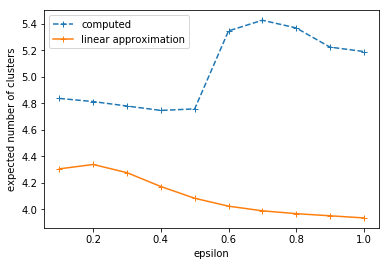

In [35]:
plt.plot(epsilon_vec, e_num_clusters_true, '+--')
plt.plot(epsilon_vec, e_num_clusters_pred, '+-')

plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

plt.legend(('computed', 'linear approximation'))

plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/pred_num_clusters2.png')

In [32]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


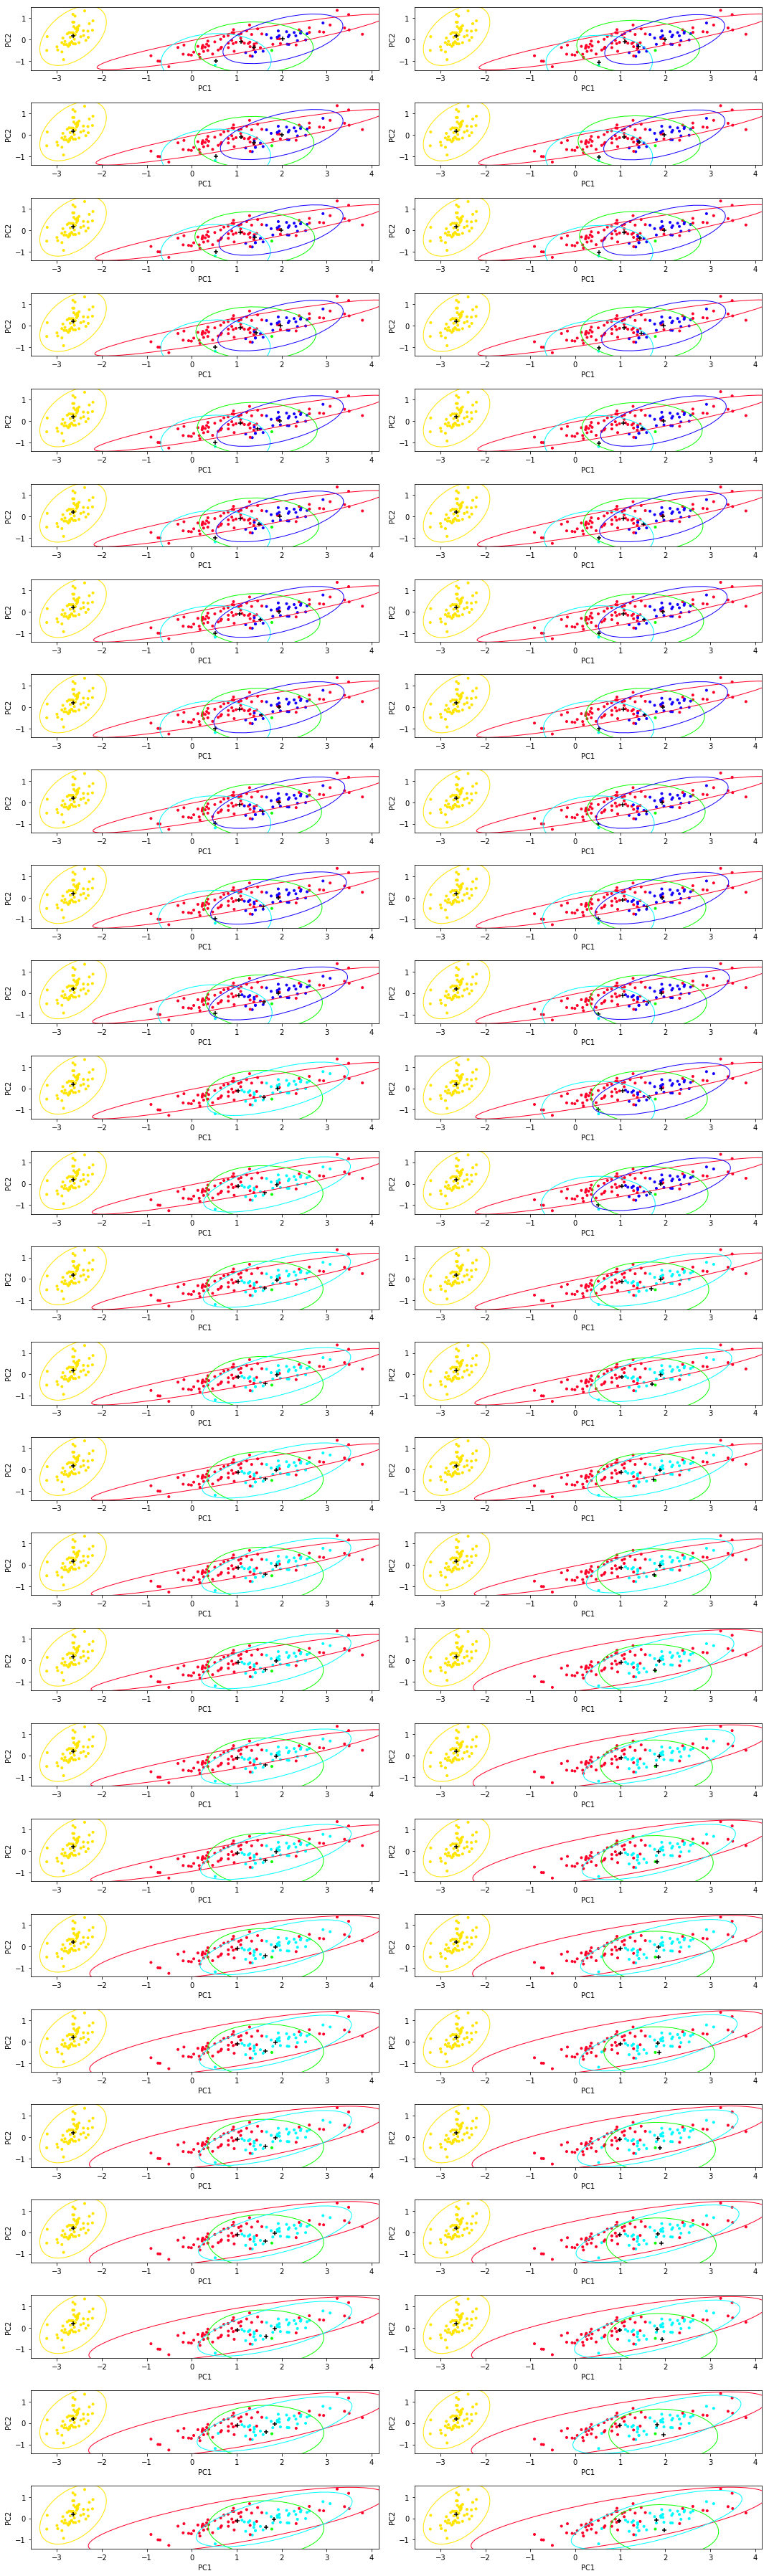

In [33]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()